In this tutorial, we'll learn some optional operations. 
### What we will learn
- How to clip an image by a rectangular shape of ROI
- How to resample an image to a target resolution
- How to calculate and create a PCA image

First, let's import necessary libraries. 

In [2]:
import rasterio 
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import json
import pycrs
import numpy as np
from rasterio.enums import Resampling
import os, glob
import matplotlib.pyplot as plt
import folium
from sklearn.decomposition import PCA

The first thing we want to do is to clip a satellite image by a region of interest (ROI) since an original image is sometimes too large to handle and takes a lot of computational power of PC.

In [4]:
opened=rasterio.open("C:\\Users\shoki\Desktop\TargetFolder\sentinel2Image.tif") #Read the sentinel-2 image we used before.

Define a ROI by specifying the coordinates of a rectangle as shown in the image below.

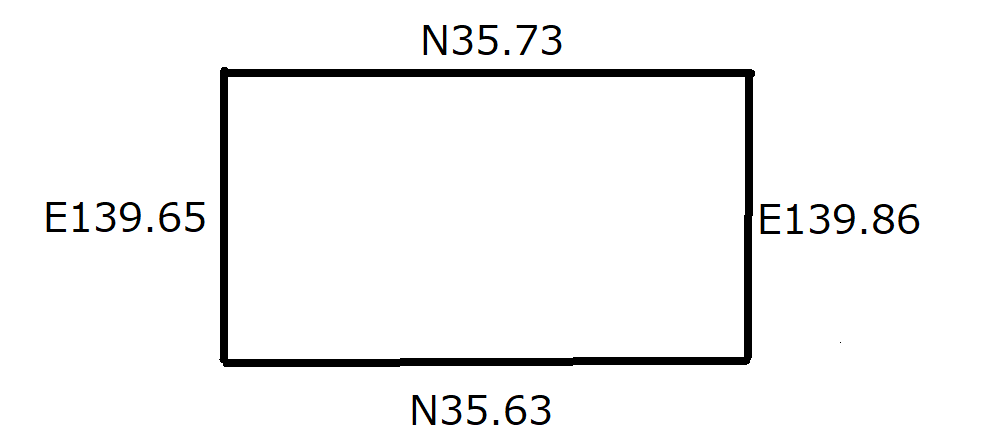

In [5]:
#Define the ROI as a rectangular.
#box(x_min,y_min,x_max,y_max)
ROI=box(139.65,35.63,139.86,35.73)

To check where the ROI is, folium library is useful.

In [152]:
map=folium.Map([35.65,139.7],zoom_start=11)
folium.GeoJson(ROI).add_to(map)
map

We need to specify what the values in the ROI variable mean. First, we set epsg:4326 (WGS84 lat/long). Then transorm the coordinates into the crs of the sentinel-2 image (epsg: 32564 UTM zone 54N).

In [6]:
geo = gpd.GeoDataFrame({'geometry': ROI}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs=opened.crs)
coords=[json.loads(geo.to_json())['features'][0]['geometry']]

C:\Users\shoki\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Get the clipped image by using a mask module of rasterio with the ROI coordinates. The outputs of the mask module is the clipped raster and the information of affine transform which is required to make a geotiff file.

In [7]:
out_img, out_transform = rasterio.mask.mask(opened, coords, crop=True)

Read bands as numpy arrays. In this case, the bands are stored in numpy array, so **the count starts from zero**. 

In [8]:
red=out_img[2]*0.0001 #Read the third band ("B4")
green=out_img[1]*0.0001 #Read the second band ("B3")
blue=out_img[0]*0.0001 #Read the first band ("B2")

In [9]:
factor=3*np.mean(red) #This is a factor to modify the image appearance. The original image is too dark to see.
trueColor = np.dstack((red,green,blue))/factor #Store the numpy arrays into another numpy array.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


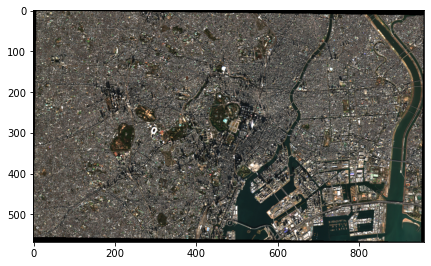

In [34]:
#Show the image.
plt.figure(figsize=(7,7))
plt.imshow(trueColor)

Save the clipped image as a geotiff file. It is important to change some of the metadata to match the scale of the clipped image. We will only use B2, B3, B4, and B8 for the output image.

In [11]:
outputPath="C:\\Users\shoki\Desktop\TargetFolder" #The path to the folder which we want to store the output.
fileName="\\ClippdByROI.tif" #The file name of the output.

driver=opened.meta["driver"]
width=out_img[0].shape[1] #Set the number of columns to match the clipped image.
height=out_img[0].shape[0] #Set the number of rows to match the clipped image.
count=4 #Set the number of bands as 4 since we only use B2, B3, B4, and B8.
crs=opened.meta["crs"]
transform=out_transform #The affine transformation is the one we've gotten from mask module.
dtype=out_img.dtype 

with rasterio.open(outputPath+fileName,
                   'w',
                  driver=driver,
                  width=width,
                  height=height,
                  count=count,
                  crs=crs,
                  transform=transform,
                  dtype=dtype) as output:
    for i in range(4): #Read bands by looping.
        output.write(out_img[i],i+1)
    output.close()

If we want to specify a resolution of the image, rasterio proveids a simple way to do that. First, we will comput the height, the widht, and the transformation (affine) of the resampled image by using "rasterio.warp.aligned_target()".

**How to use rasterio.warp.aligned_target()**

target_transform, target_width, target_height=rasterio.warp.aligned_target(source_transform, source_width, source_height, resolution)<br>
**The unit of the resolution is same as the unit of the CRS of the image. If we use UTM (unit: m), there are no problems. However, it the unit of the CRS is degree (ex: WGS84), we need to give the resolution in a unit of degree.**

In [12]:
#We are going to resample the sentinel-2 image to 500 m resolution which is a typical scale of MODIS products.

source_transform=opened.meta["transform"]
source_width=opened.meta["width"]
source_height=opened.meta["height"]
resolution=500

target_transform,target_width,target_height=\
        rasterio.warp.aligned_target(source_transform, source_width, source_height, resolution)

In [13]:
#Apply a resampling method on the image.
#We use the bilinear method for the resampling.
resampled_img=opened.read(out_shape=(target_height,target_width),resampling=Resampling.bilinear)

In [14]:
red=resampled_img[2]*0.0001 #Read the third band ("B4")
green=resampled_img[1]*0.0001 #Read the second band ("B3")
blue=resampled_img[0]*0.0001 #Read the first band ("B2")

In [15]:
factor=3*np.mean(red) #This is a factor to modify the image appearance. The original image is too dark to see.
trueColor_resampled = np.dstack((red,green,blue))/factor #Store the numpy arrays into another numpy array.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


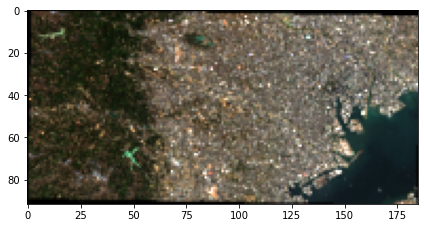

In [35]:
#Show the image.
plt.figure(figsize=(7, 7))
plt.imshow(trueColor_resampled)

The resampled image is very much coarse compared to the original sentinel-2 image. Let's export the resampled image in a geotiff file.

In [17]:
outputPath="C:\\Users\shoki\Desktop\TargetFolder" #The path to the folder which we want to store the output.
fileName="\\Resampled.tif" #The file name of the output.
with rasterio.open(outputPath+fileName,
                  'w',
                  driver=opened.meta["driver"],
                  width=target_width,
                  height=target_height,
                  count=opened.meta["count"],
                  crs=opened.meta["crs"],
                  transform=target_transform,
                  dtype=resampled_img.dtype) as output:
    for i in range(11):
        output.write(resampled_img[i],i+1)
    output.close()

We can check that the resolution of the output product is 500 m by using the metadata of the image.

In [18]:
opened_resampled=rasterio.open(outputPath+fileName)
opened_resampled.meta["transform"] #The resolution of the affine transform is set to 500 m.

Affine(500.0, 0.0, 315000.0,
       0.0, -500.0, 3967500.0)

Next, we will try to do the principal component analysis (PCA) on the image. PCA helps us reduce the number of bands that contain important information. By using PCA, we can produce a smaller number of bands compared to the original image. PCA uses eigen vectors and eigen values of the covariance matrix of the data. For more detailed explanations of PCA, [this video](https://youtu.be/FgakZw6K1QQ) will be helpful.

First, read bands as numpy arrays. I added ".flatten()" at the end of ".read". "flatten()" changes the shape of an array into a single vector. This conversion is needed for later procedures.

In [19]:
B2=opened.read(1).flatten()
B3=opened.read(2).flatten()
B4=opened.read(3).flatten()
B5=opened.read(4).flatten()
B6=opened.read(5).flatten()
B7=opened.read(6).flatten()
B8=opened.read(7).flatten()
B8A=opened.read(8).flatten()
B9=opened.read(9).flatten()
B11=opened.read(10).flatten()
B12=opened.read(11).flatten()

Next, combine all the bands into one array by using "np.dstack". 

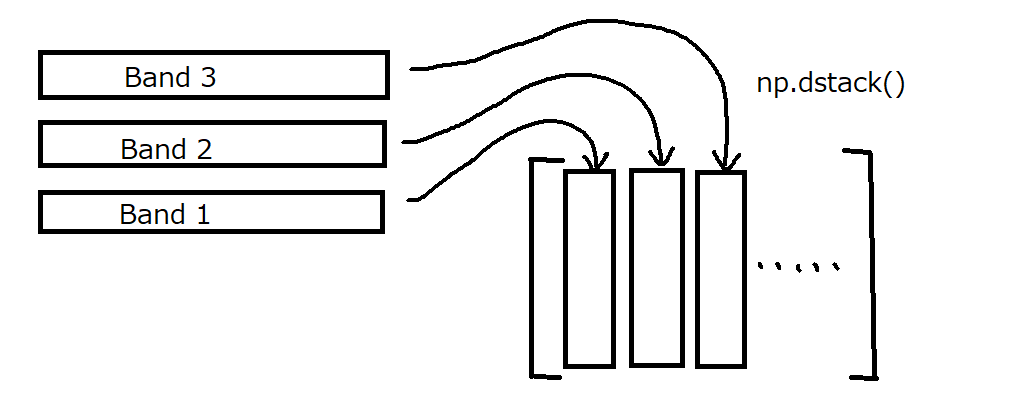

In [20]:
stackedImage=np.dstack((B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12))

In [21]:
stackedImage[0].shape #stackedImage array has 10412490 rows and 11 colmuns.

(10412490, 11)

In [22]:
pca = PCA(n_components=10) #We set the number of principal components to ten.

In [23]:
pca.fit(stackedImage[0]) #Apply PCA on the bands.

PCA(n_components=10)

Let's see the variance explained by each principal component (PC). We don't need to use PCs that explain the variance poorly.

Text(0, 0.5, 'Variance explained [%]')

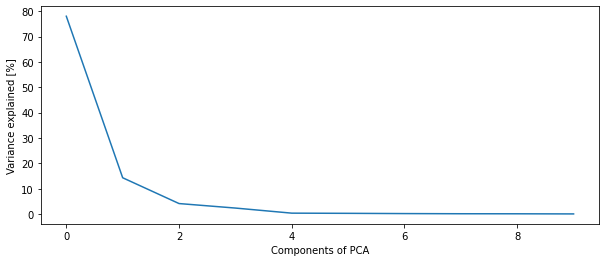

In [24]:
variance=pca.explained_variance_ 
totalVariance=np.sum(variance)
variance=variance/totalVariance*100
figure=plt.figure(figsize=(10,4))
ax=figure.subplots()
ax.plot(variance)
ax.set_xlabel("Components of PCA")
ax.set_ylabel("Variance explained [%]")

According to the variance and PCs graph, we can see that most of the variance of the image is explained by the first, the second, and the third PCs. Therefore, the number of bands is reduced to only three from the original eleven.

In [25]:
pcaImage=pca.transform(stackedImage[0]) #Get the PCs image.

In [26]:
width=opened.meta["width"]
height=opened.meta["height"]
shape=(height,width)

#Get the first, the second, and the third component image as a vector form, 
#then reshape them into the original numpy arrays.
firstComponent=pcaImage[:,0].reshape(shape) 
secondComponent=pcaImage[:,1].reshape(shape)
thirdComponent=pcaImage[:,2].reshape(shape)

In [27]:
pcaImageStack=np.dstack((firstComponent,secondComponent,thirdComponent))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


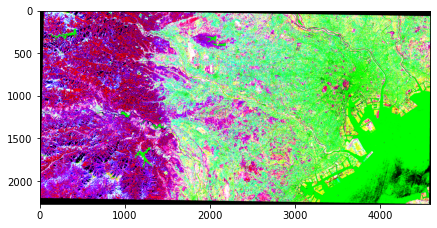

In [36]:
plt.figure(figsize=(7, 7))
plt.imshow(pcaImageStack) #This is the image of PCs.